In [14]:
"""
Created on Sun Oct  8 15:56:24 2017

@author: Michael Di Amore
"""


import Query as query
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from matplotlib import pyplot as plt
from collections import Counter
%matplotlib inline

## Goal:
    Provide an example framework for querying and modeling the gdelt events 
    database. Note that this is different than the gdelt knowledge database 
    and is a much smaller database. I think we should speak with our mentors 
    about which one they would prefer to use. The cost of querying on the 
    knowledge databseis quite high. As it quickly hits the 1TB limit and starts charging you.
    around 5 dollars a query.
    
    I start with a sanity check by exploring the data visually, then I do the
    simplest preprocessing possible followed by a rudimentary model as well
    
    This is just to serve as an example for how to get started. It's not meant
    to be streamlined yet.


## Details:
    I run a query on the events database from the start of the year till now,
    focusing on US events only, I then produce some basic visualizations of the data. I then follow up
    with a basic SVR using a Guassian Kernel and some basic data preprocessing to turn it into a supervise
    learning problem to predict the VIX index. 





## Querying:
    Below is the querying code in action, with a simple SQL query and a ticker we can create an object to query both yahoo and GDELT

In [3]:
proj_id = 'capstone-v0'
start_date = '2017-01-01'
end_date = '2017-10-06'
ticker = '^VIX'
my_query = query.query_tool(proj_id,start_date,end_date,ticker)
sql_query = """
            SELECT Actor1Name, Actor2Name, GoldsteinScale,NumMentions,sourceurl,
            sqldate, avgtone, numarticles, numsources,  
            FROM [gdelt-bq:full.events] 
            WHERE sqldate > 20170101 and sqldate <= 20171006  and 
                Actor1Geo_CountryCode like "%US%" and 
                Actor1Code like "%BUS%"
            """
my_query.query_gdelt(sql_query)
my_query.gdelt_df = my_query.gdelt_df.set_index('sqldate',drop=True).sort_index()
df = my_query.gdelt_df.copy(True)

Requesting query... ok.
Job ID: job_8TduaQI1NdN0a6JnatsjsQPDhuRi
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 12% done. Elapsed 11.25 s.
  Got page: 3; 18% done. Elapsed 16.96 s.
  Got page: 4; 24% done. Elapsed 22.88 s.
  Got page: 5; 30% done. Elapsed 28.37 s.
  Got page: 6; 36% done. Elapsed 34.51 s.
  Got page: 7; 42% done. Elapsed 40.62 s.
  Got page: 8; 48% done. Elapsed 48.0 s.
  Got page: 9; 54% done. Elapsed 53.92 s.
  Got page: 10; 60% done. Elapsed 61.67 s.
  Got page: 11; 66% done. Elapsed 69.2 s.
  Got page: 12; 72% done. Elapsed 76.91 s.
  Got page: 13; 78% done. Elapsed 84.56 s.
  Got page: 14; 84% done. Elapsed 92.03 s.
  Got page: 15; 90% done. Elapsed 97.9 s.
  Got page: 16; 96% done. Elapsed 104.22 s.
  Got page: 17; 100% done. Elapsed 107.97 s.
Got 646606 rows.

Total time taken 122.97 s.
Finished at 2017-10-08 16:53:23.


## Exploration

Some basic data exploration of both the discrete and continuous variables. I wanted to highlight the most popular news 
outlets and topics along with the distribution of the sentiment indicators

In [8]:
#Split the source column and do some wrangling
df['sourceurl'] = df['sourceurl'].str.replace('http://','')
df['sourceurl'] = df['sourceurl'].str.replace('https://','')
df['sourceurl'] = df['sourceurl'].str.replace('www.','')
df['sourceurl'] = df['sourceurl'].str.split('/').str[0]

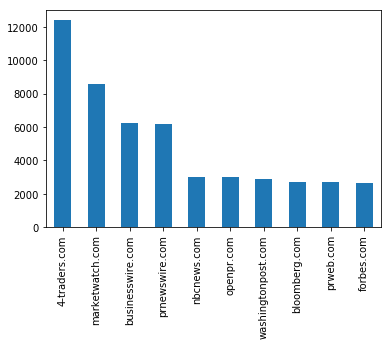

In [9]:
#Count and plot source url
plt.figure(0)
source_counts = df['sourceurl'].value_counts().head(10)
source_counts.plot.bar()

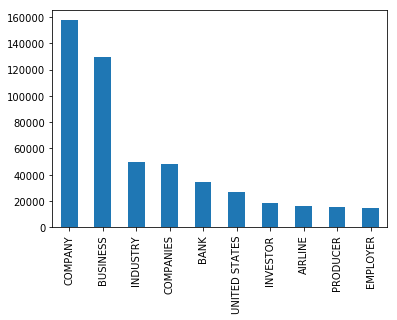

In [10]:
#Count and plot actor 1 Name
plt.figure(1)
actor_counts = df['Actor1Name'].value_counts().head(10)
actor_counts.plot.bar()

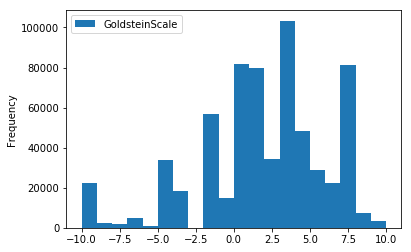

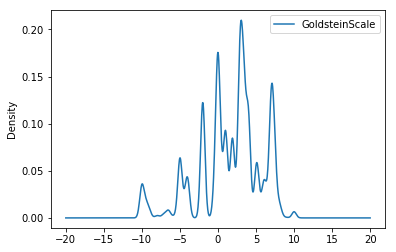

In [11]:
#Empirical Disribution of Goldstein Scale
plt.figure(2)
df['GoldsteinScale'].plot.hist(bins=(20),legend=True)
plt.figure(3)
df['GoldsteinScale'].plot.kde(legend=True)

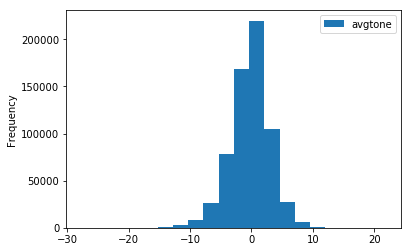

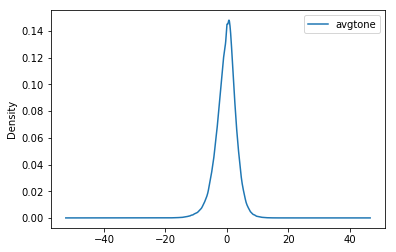

In [12]:
#Empirical Distribution of avgtone
plt.figure(4)
df['avgtone'].plot.hist(bins=(20),legend=True) #looks Guassian
plt.figure(5)
df['avgtone'].plot.kde(legend=True)

## Modeling

Basic model, just using a SVR with Gaussian kernel. Preprocessing is very simple as well. Just doing a groupby sum to collapse the dataframe and allow for transformation into (x,y) pairs for supervised learning.

/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


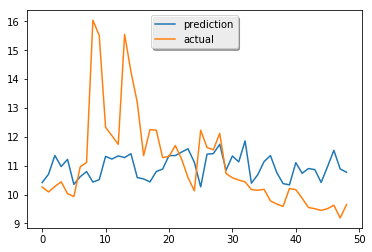

In [13]:
#Collapse numerical data into x,y pairs in simplest way possible, taking sums
collapsed = df.groupby(by=df.index).sum()
collapsed.index = pd.to_datetime(collapsed.index,format='%Y%m%d')
vix_prices = my_query.query_yahoo()
vix_prices = vix_prices['Adj Close']

#Since vix is only 5 days a week and collapsed is all days we make them equal
#in reality we might be able to predict the monday using the weekend?
collapsed = collapsed.ix[vix_prices.index].dropna()


#Preprocessing:
X_train,X_test,Y_train,Y_test = train_test_split(collapsed,vix_prices,shuffle=False)


ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Basic Support Vector Regression Model, to predict the vix index
basic_svr = SVR()
basic_svr = basic_svr.fit(X_train_scaled,Y_train)
cv_svr = GridSearchCV(basic_svr,param_grid={'C':[0.5,1,100,500,1000],'epsilon':[0.01,0.001,0.0001]})
cv_svr.fit(X_train_scaled,Y_train)

pred = cv_svr.predict(X_test_scaled)
actual = np.array(Y_test)

fig = plt.figure(6)
fig, ax = plt.subplots()
ax.plot(pred, label='prediction')
ax.plot(actual, label='actual')
legend = ax.legend(loc='upper center', shadow=True)